# Data Deduplication using Clustering
**Objective**: Learn and implement data deduplication techniques.

**Task**: DBSCAN for Data Deduplication

**Steps**:
1. Data Set: Download a dataset containing duplicate entries for event registrations.
2. DBSCAN Clustering: Apply the DBSCAN algorithm to cluster similar registrations.
3. Identify Duplicates: Detect duplicates based on density of the clusters.
4. Refinement: Validate clusters and remove any erroneous duplicates.

Original DataFrame with Potential Duplicates:
   RegistrationID        Name                  Email       Event  \
0               1  Attendee 1  attendee1@example.com   Seminar C   
1               2  Attendee 2  attendee2@example.com  Workshop A   
2               3  Attendee 3  attendee3@example.com   Seminar C   
3               4  Attendee 4  attendee4@example.com   Seminar C   
4               5  Attendee 5  attendee5@example.com  Workshop A   

            Timestamp  
0 2025-05-16 12:42:38  
1 2025-05-16 20:06:49  
2 2025-05-16 19:46:51  
3 2025-05-16 18:14:57  
4 2025-05-16 10:17:45  

DataFrame with Cluster Assignments (-1 indicates noise):
   RegistrationID        Name                  Email       Event  \
0               1  Attendee 1  attendee1@example.com   Seminar C   
1               2  Attendee 2  attendee2@example.com  Workshop A   
2               3  Attendee 3  attendee3@example.com   Seminar C   
3               4  Attendee 4  attendee4@example.com   Seminar C   
4  

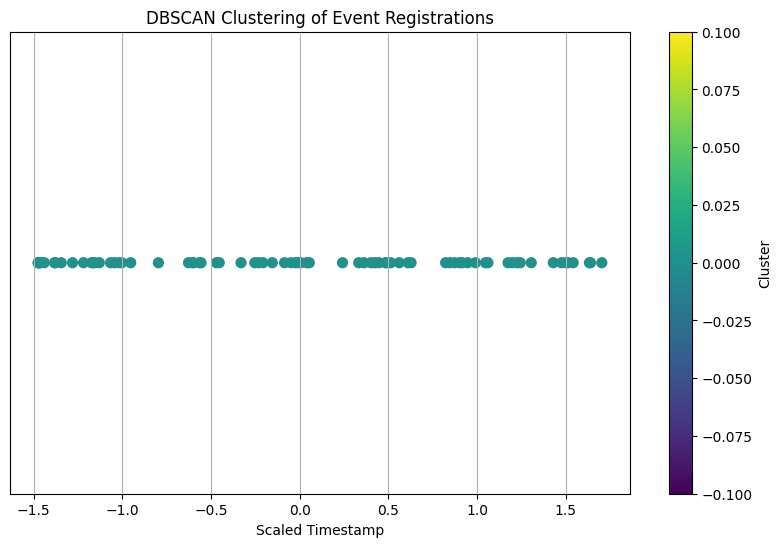

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# Step 1: Generate a dataset containing duplicate entries for event registrations (replace with your actual data)
np.random.seed(42)
num_records = 70
data = {
    'RegistrationID': np.arange(1, num_records + 1),
    'Name': [f'Attendee {i}' for i in range(1, num_records + 1)],
    'Email': [f'attendee{i}@example.com' for i in range(1, num_records + 1)],
    'Event': np.random.choice(['Workshop A', 'Conference B', 'Seminar C'], num_records),
    'Timestamp': pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(0, 86400, num_records), unit='s')
}
df = pd.DataFrame(data)

# Introduce some duplicates with slight variations (e.g., slightly different timestamps or names)
df_duplicates = pd.DataFrame({
    'RegistrationID': [71, 72, 73, 74, 75],
    'Name': ['Attendee 5', 'Attende 18', 'Attendee 33', 'Attendee 59', 'Attendee 68'], # Slight typos
    'Email': ['attendee5@example.com', 'attendee18@example.com', 'attendee33@example.com', 'attendee59@example.com', 'attendee68@example.com'],
    'Event': ['Workshop A', 'Conference B', 'Seminar C', 'Workshop A', 'Conference B'],
    'Timestamp': [pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(100, 500), unit='s'),
                  pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(200, 600), unit='s'),
                  pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(50, 300), unit='s'),
                  pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(150, 450), unit='s'),
                  pd.to_datetime('2025-05-16') + pd.to_timedelta(np.random.randint(250, 700), unit='s')]
})

df = pd.concat([df, df_duplicates], ignore_index=True)
np.random.shuffle(df.values) # Shuffle the order

print("Original DataFrame with Potential Duplicates:")
print(df.head())

# Step 2: DBSCAN Clustering: Apply the DBSCAN algorithm to cluster similar registrations.
# Select features for clustering. For simplicity, let's use the timestamp numerically.
# You might want to engineer more features based on name similarity, email similarity, etc.
df['Timestamp_Numeric'] = df['Timestamp'].astype(np.int64) // 10**9 # Convert to seconds since epoch
X = df[['Timestamp_Numeric']].copy()

# Standardize the numerical feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
# eps: Maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
# These parameters need to be tuned based on your data.
epsilon = 0.5 # In the scaled space
min_samples = 2
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
df['Cluster'] = dbscan.fit_predict(X_scaled)

print("\nDataFrame with Cluster Assignments (-1 indicates noise):")
print(df.head())

# Step 3: Identify Duplicates: Detect duplicates based on density of the clusters.
# Records within the same cluster (cluster != -1) are potential duplicates.
# Noise points (cluster == -1) are considered unique.

def identify_duplicates_dbscan(cluster_df):
    if len(cluster_df) <= 1:
        return cluster_df
    # For simplicity, let's consider all records within a cluster as potential duplicates
    # and keep the first occurring one based on RegistrationID.
    return cluster_df.sort_values(by='RegistrationID').iloc[[0]]

# Group by cluster and keep only one representative record
df_deduplicated = df[df['Cluster'] != -1].groupby('Cluster', group_keys=False).apply(identify_duplicates_dbscan).reset_index(drop=True)
df_unique_noise = df[df['Cluster'] == -1].copy() # Add noise points back as unique

df_final = pd.concat([df_deduplicated, df_unique_noise]).sort_values(by='RegistrationID').reset_index(drop=True)

print("\nDeduplicated DataFrame:")
print(df_final.head())
print(f"\nNumber of original records: {len(df)}")
print(f"Number of deduplicated records: {len(df_final.drop_duplicates(subset=['Name', 'Email', 'Event', 'Timestamp']))}")

# Step 4: Refinement: Validate clusters and remove any erroneous duplicates.
# This step often involves manual inspection or further analysis based on domain knowledge.
# For example, you might want to look at clusters with more than a certain number of records.

# Example of inspecting clusters:
print("\nCluster Sizes:")
print(df['Cluster'].value_counts())

# Further refinement could involve:
# - Using more sophisticated feature engineering (e.g., string similarity for names and emails).
# - Applying another clustering algorithm or rule-based system on the identified clusters.
# - Manual review of clusters with high cardinality.

# Optional: Visualize the clusters (if using more than one feature, you'd need dimensionality reduction)
if X_scaled.shape[1] == 1:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_scaled, np.zeros_like(X_scaled), c=df['Cluster'], cmap='viridis', s=50)
    plt.xlabel('Scaled Timestamp')
    plt.yticks([])
    plt.title('DBSCAN Clustering of Event Registrations')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()
    